# 開始点と音色の判定を同時に行う

- input device 1
- output device 10

In [1]:
import sounddevice as sd
import numpy as np
import socket
import librosa
import sys
import math
import matplotlib.pyplot as plt
import time as ti

import tensorflow
from tensorflow import keras
from keras.models import load_model

In [2]:
sr = 22050
shift_size = 576
data_length = 1

hop_length = 1024
frame_length = 2048
pre_max = 30 / 1000 * sr // hop_length
post_max = 0 / 1000 * sr // hop_length + 1
pre_avg = 100 / 1000 * sr // hop_length
post_avg = 100 / 1000 * sr // hop_length + 1
wait = 300 / 1000 * sr // hop_length
delta = 0.4

model = load_model("C:/Users/shuhei/anaconda3/envs/tensorflow/workspace/models/models_guitar/guitar_.08_0.0511_0.9567.hdf5")

In [3]:
def calculate_melsp(x, n_fft=1024, hop_length=128):
    stft = np.abs(librosa.stft(x, n_fft=n_fft, hop_length=hop_length))**2
    log_sftf = librosa.power_to_db(stft)
    melsp = librosa.feature.melspectrogram(S=log_sftf, n_mels=128)
    return melsp

def min_max_normalize(x, axis=None):
    min = x.min(axis=axis, keepdims=True)
    max = x.max(axis=axis, keepdims=True)
    result = (x-min)/(max-min)
    return result

def onset_detection(y, sr, rate, frame_length, hop_length, params):
    rms = librosa.feature.rms(y=y*rate, frame_length=frame_length, hop_length=hop_length, center=False)
    onset_envelope = rms[0, 1:] - rms[0, :-1]
    onset_envelope = np.maximum(0.0, onset_envelope)
    onset_frames = librosa.util.peak_pick(onset_envelope, pre_max=params["pre_max"], post_max=params["post_max"], pre_avg=params["pre_avg"], post_avg=params["post_avg"], delta=params["delta"], wait=params["wait"])
    times = librosa.times_like(onset_envelope, sr=sr, hop_length=hop_length)
    return onset_envelope, onset_frames, times

def create_array(full_data, detected_num):
    window_size = 22050
    front_padding = 22050
    back_padding = 44100
    result = []

    for i in detected_num:
        start = max(0, i - front_padding)
        end = min(len(full_data), i + back_padding)

        if end - start < front_padding + back_padding:
            # Padding if the window size is not fully covered
            padding_start = max(0, front_padding - i)
            padding_end = max(0, back_padding - (len(full_data) - i))
            cliped_data = np.pad(full_data[start:end], (padding_start, padding_end), mode='constant')
        else:
            cliped_data = full_data[start:end]

        result.append(cliped_data)

    return np.array(result)

def predict_performances(y, model):
    x = y.reshape(len(y))
    melsp = calculate_melsp(x)
    
    pred = model.predict(melsp.reshape(1, 128, 517, 1))
    pred_label = np.argmax(pred)
        
    if pred_label == 0:
        return "good!!"
    elif pred_label == 1:
        return "normal"
    elif pred_label == 2:
        return "bad!!"

def callback_pitch(indata, frames, time, status):
    global data, onset_frames, non_negative_data, start_time, full_data
    data = np.roll(data, -shift_size, axis=0)
    data[-shift_size:] = indata.reshape((shift_size,))
    full_data = np.roll(full_data, -shift_size, axis=0)
    full_data[-shift_size:] = indata.reshape((shift_size,))

    src = data.reshape(data.size) * 100
    rms = librosa.feature.rms(y=src, frame_length=frame_length, hop_length=hop_length, center=False)
    onset_envelope = rms[0, 1:] - rms[0, :-1]
    onset_envelope = np.maximum(0.0, onset_envelope)
    onset_frames = librosa.util.peak_pick(onset_envelope, pre_max=pre_max, post_max=post_max, pre_avg=pre_avg, post_avg=post_avg, delta=delta, wait=wait)
  
    if len(onset_frames) != 0:
        _times = librosa.times_like(onset_envelope, sr=sr, hop_length=hop_length)
        for onset_frame in onset_frames:
            elapsed_time = (ti.time() - start_time) - (data_length - _times[onset_frame])
            
            if any(abs(elapsed_time - t) < 1.0 for t in detected_onset_times):
                continue
                
            detected_onset_times.append(elapsed_time)
            
            print(f"detect onset: {elapsed_time}")
            sock = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
            sock.sendto(str(elapsed_time).encode('utf-8'), (HOST, PORT))

def receive_unity_instruction(server_ip, server_port):    
    # ソケットを作成してバインド
    server_socket = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    server_socket.bind((server_ip, server_port))
    
    # クライアントからの接続を待機
    server_socket.listen(1)
    print(f"Waiting for connection on {server_ip}:{server_port}")
    
    # 接続を受け入れる
    client_socket, client_address = server_socket.accept()
    print(f"Connected by {client_address}")
    
    # データの受信と表示
    data = client_socket.recv(1024)
    print(f"Received data: {data.decode('utf-8')}")
    
    # ソケットを閉じる
    client_socket.close()
    server_socket.close()

    if data.decode('utf-8') == '0001':
        return True
    else:
        print("connection error")
        return False

def send_data_to_server(server_ip, server_port, message):
    # ソケットを作成
    with socket.socket(socket.AF_INET, socket.SOCK_DGRAM) as client_socket:
        # メッセージをサーバーに送信
        client_socket.sendto(message.encode('utf-8'), (server_ip, server_port))

input device:  Mic | Line 1/2 (Audient EVO4) 

output device:  Main Output 1/2 (Audient EVO4) 



duration:  20


Waiting for connection on 192.168.0.25:50003
Connected by ('192.168.0.25', 61610)
Received data: 0001
20.001391172409058


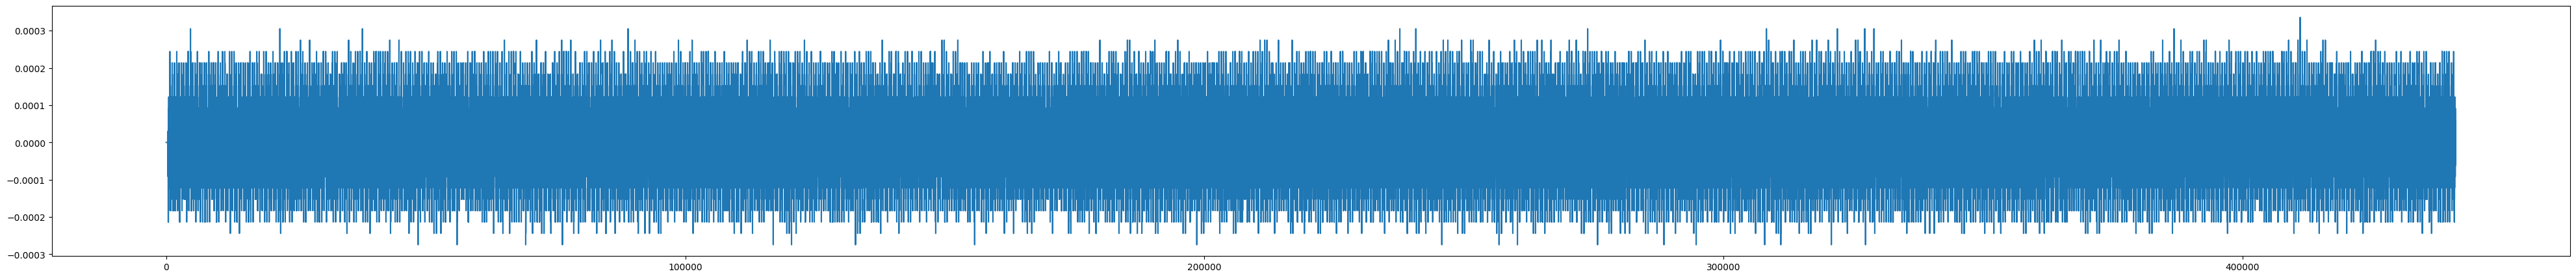

Send message: 0,0,0


In [5]:
# input_device = int(input("input device number: "))
# output_device = int(input("output device number: "))
input_device = 1
output_device = 10

sd.default.device = [input_device, output_device]

print("input device: ", sd.query_devices(kind="input")["name"], "\n")
print("output device: ", sd.query_devices(kind="output")["name"], "\n")

duration = int(input("duration: "))

LOCAL_HOST = "192.168.0.25"
# HOST = "192.168.0.26"
HOST = "192.168.0.25"
PORT = 50003

data = np.zeros(int(sr)*data_length, dtype=np.float32)
full_data = np.zeros(int(sr)*duration, dtype=np.float32)
onset_frames = []
detected_onset_times = []

if receive_unity_instruction(LOCAL_HOST, PORT):
    pass
else:
    print("error")

with sd.InputStream(
            samplerate=sr,
            channels=1,
            dtype='float32',
            callback=callback_pitch
        ):
        start_time = ti.time()
        sd.sleep(int(duration * 1000))
        print(ti.time() - start_time)
        sock = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
        sock.sendto(str(0000).encode('utf-8'), (HOST, PORT))

detected_num = [int((detected_onset_time * sr) + frame_length) for detected_onset_time in detected_onset_times]
cliped_datas = create_array(full_data, detected_num)

fig = plt.figure(figsize=(50, 5))
ax = fig.add_subplot(111)

ax.plot(full_data, label='onset envelope')
ax.vlines(detected_num, 0, 1, color='r', linestyle='--', label='onsets')
plt.show()

good_num = 0
normal_num = 0
bad_num = 0

for dst in cliped_datas:
    result = predict_performances(dst, model)
    if result == "good!!":
        good_num += 1
    elif result == "normal":
        normal_num += 1
    elif result == "bad!!":
        bad_num += 1
    print(result)

message_to_send = str(good_num) + "," + str(normal_num) + "," + str(bad_num)
# send_data_to_server(HOST, PORT, message_to_send)
print(f"Send message: {message_to_send}")